# Model quality - comparison with deep mutational scan



In [1]:
import os, sys
import numpy as np
import scipy as sci
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
#############################
#                           #
#                           #
#        CONSTANTS          #
#                           #
#                           #
#############################
LOCAL_DIR = '.'
DATA_DIR = LOCAL_DIR+'/data'
OUTPUT_DIR = LOCAL_DIR+'/figures/model_quality_dms'
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

In [3]:
from importlib import reload
sys.path.append(LOCAL_DIR) #Helper Functions Here
import FramHelperScripts
reload(FramHelperScripts)
FHS = FramHelperScripts.FramHelperFunctions(DATA_DIR)

## Load data

In [4]:
#############################
#                           #
#                           #
#        LOAD DATA          #
#                           #
#                           #
#############################
seqs_df = FHS.get_sequences_df()
dms_df = FHS.get_dms_df()

#load the model mutation fitness prediction values
model = FHS.get_model()
df_evh_singles = FHS.get_model_mutation_effect_table()

In [5]:
#add prediction to dataframe
dms_df = pd.merge(
    left=dms_df, 
    right=df_evh_singles[['mutant', 'effect_prediction_epistatic']],
    left_on='model_mutation', right_on='mutant'
)[[
    'stiffler_mutation', 'model_mutation', 
    'stiffler_position', 
    'amp_conc', 
    'rep1_value', 'rep2_value',
    'effect_prediction_epistatic'
]]

## Correlation with Deep Mutational Scan

In [6]:
def plot_dms_vs_evh(amp_conc, rep_num, avg=False, legend_loc='lower right', save=False):
    dms_val_col = 'rep{0}_value'.format(rep_num)
    tmp_df = dms_df[
        dms_df.amp_conc==amp_conc
    ][[
        'stiffler_position', 
        'effect_prediction_epistatic',
        dms_val_col
    ]].dropna(axis='rows')

    if avg:
        tmp_df = tmp_df.groupby('stiffler_position').mean()

    spearman = sci.stats.spearmanr(
        tmp_df.effect_prediction_epistatic, tmp_df[dms_val_col]
    )

    xlim = (-12, 2)
    xlabel = 'predicted effect of mutation (ΔEVH)'
    if avg:
        xlim = (-10, -2)
        xlabel = 'predicted effect of all mutations\nat position (average ΔEVH)'

    jp = sns.jointplot(
        x=tmp_df.effect_prediction_epistatic, 
        y=tmp_df[dms_val_col], 
        color='steelblue' if not avg else 'firebrick',
        label='single mutation',
        marginal_kws=dict(
            bins=50 if not avg else 25 
        ),
        xlim=xlim
    )
    jp.fig.suptitle(
        'DMS rep {0} - {1} ug/mL amp\nspearman={2:.3f} (n={3})'.format(
            rep_num, amp_conc, spearman.statistic, len(tmp_df)
        )
    )
    jp.set_axis_labels(
        xlabel, 'experimentally measured fitness score'
    )
    sns.move_legend(jp.ax_joint, legend_loc)
    jp.fig.tight_layout()
    jp.fig.subplots_adjust(top=0.92) # Reduce plot to make room
    if save:
        jp.fig.savefig(OUTPUT_DIR+'/evh_dms_corr_amp{0}_rep{1}_{2}.pdf'.format(
            amp_conc, rep_num, 'avg' if avg else 'all'
        ))

/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_7611/2258329859.py:43: UserWarning: The figure layout has changed to tight
  jp.fig.tight_layout()
/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_7611/2258329859.py:43: UserWarning: The figure layout has changed to tight
  jp.fig.tight_layout()
/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_7611/2258329859.py:43: UserWarning: The figure layout has changed to tight
  jp.fig.tight_layout()
/var/folders/9p/fjc932bj5n11050s1nv1kvdc0000gn/T/ipykernel_7611/2258329859.py:43: UserWarning: The figure layout has changed to tight
  jp.fig.tight_layout()


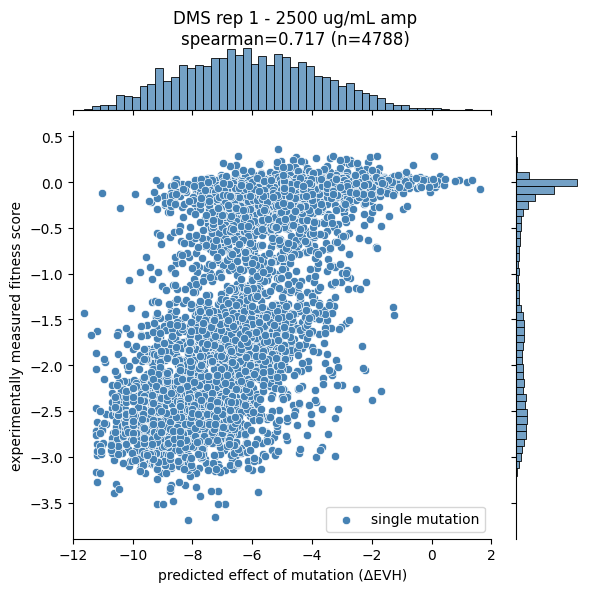

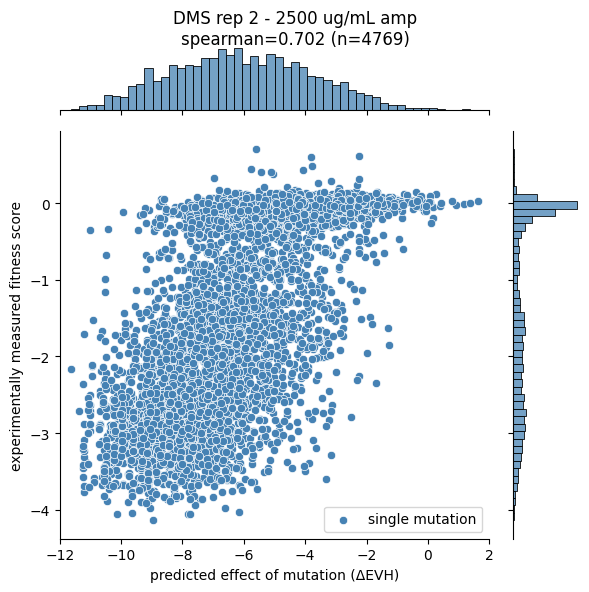

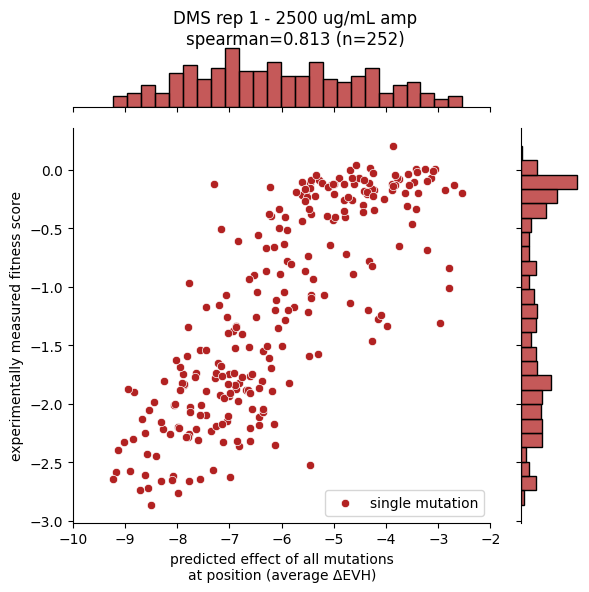

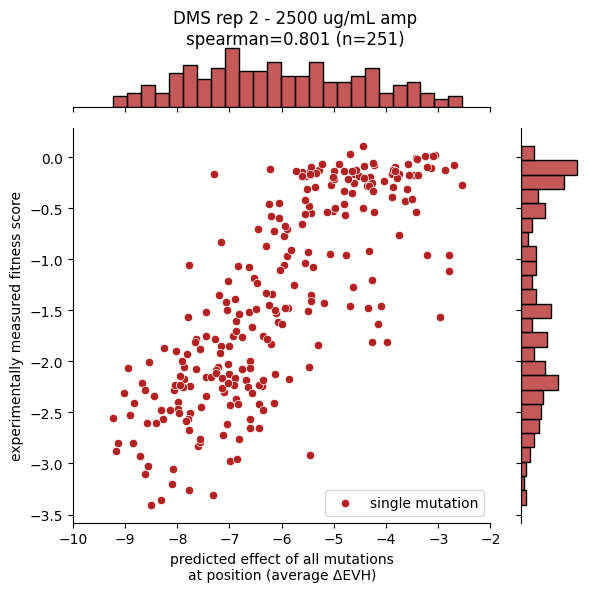

In [7]:
#output 2500
plot_dms_vs_evh(2500, 1, save=True)
plot_dms_vs_evh(2500, 2, save=True)
plot_dms_vs_evh(2500, 1, avg=True, save=True)
plot_dms_vs_evh(2500, 2, avg=True, save=True)


In [8]:
def get_source_data():
    tmp_df = dms_df[
        dms_df.amp_conc==2500
    ][[
        'stiffler_mutation',
        'effect_prediction_epistatic',
        'rep1_value',
        'rep2_value',
    ]].dropna(
        axis='rows'
    ).rename(columns={
        'stiffler_mutation': 'mutation (dms numbering)',
        'effect_prediction_epistatic': 
            'X-axis - predicted effect of mutation (delta EVH)',
        'rep1_value': 
            'Y-axis - experimentally measured fitness score - replicate 1',
        'rep2_value': 
            'Y-axis - experimentally measured fitness score - replicate 2',
    }).reset_index(
        drop=True
    )
    return tmp_df

get_source_data().to_csv(
    OUTPUT_DIR+'/evh_dms_corr_amp2500.tab', 
    sep ='\t', 
    index=False
)
    
#sns.scatterplot(
#    get_source_data(),
#    x='X-axis - predicted effect of mutation (delta EVH)',
#    y='Y-axis - experimentally measured fitness score - replicate 1'
#)
#plt.show()
#sns.scatterplot(
#    get_source_data(),
#    x='X-axis - predicted effect of mutation (delta EVH)',
#    y='Y-axis - experimentally measured fitness score - replicate 2'
#)